In [1]:
def contours(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    canny_output = cv2.Canny(gray, 10, 30)
    contours, hierarchy = cv2.findContours(canny_output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
    new_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 50:
            new_contours.append(contour)
    return new_contours

In [2]:
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import filters
import pdi

In [3]:
IMAGE_FOLDER = "./"
INPUT_IMAGE = "0.bmp"
BG_IMAGE = 'red.png'
INVERT_RGB = True

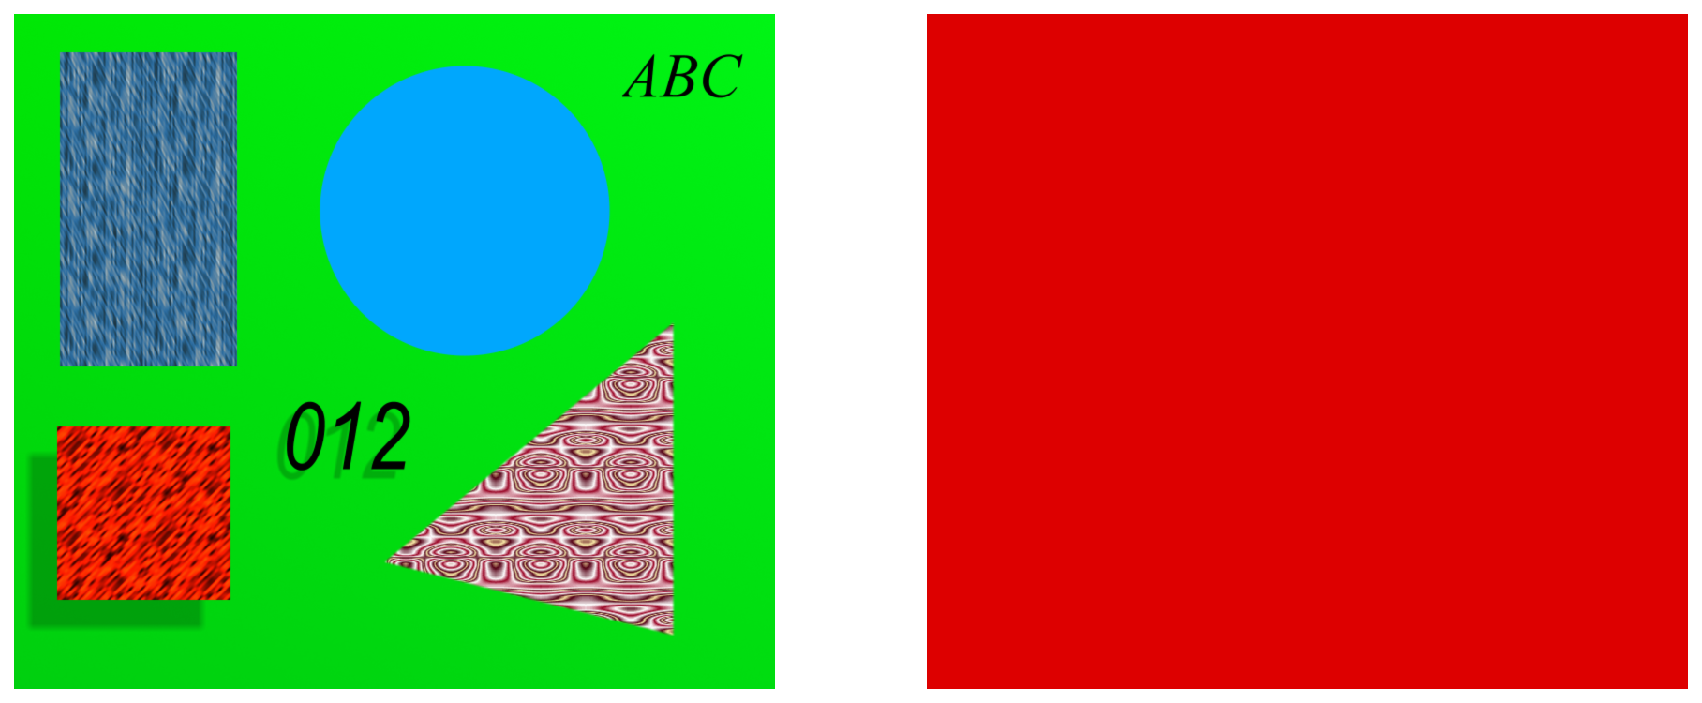

In [4]:
img = cv2.imread(f"{IMAGE_FOLDER}/{INPUT_IMAGE}")
bg_img = cv2.imread(f"{IMAGE_FOLDER}/{BG_IMAGE}")
if img is None or bg_img is None:
    print("Erro ao abrir a imagem")
h, w, _ = img.shape
if INVERT_RGB:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    bg_img = cv2.cvtColor(bg_img, cv2.COLOR_RGB2BGR)
img = cv2.GaussianBlur(img, (3, 3), 0.5)
bg_img = cv2.resize(bg_img, (w, h))

fig = plt.figure(figsize=(15, 15))
fig.add_subplot(121)
plt.axis('off')
plt.imshow(img)
fig.add_subplot(122)
plt.axis('off')
plt.imshow(bg_img)
del fig

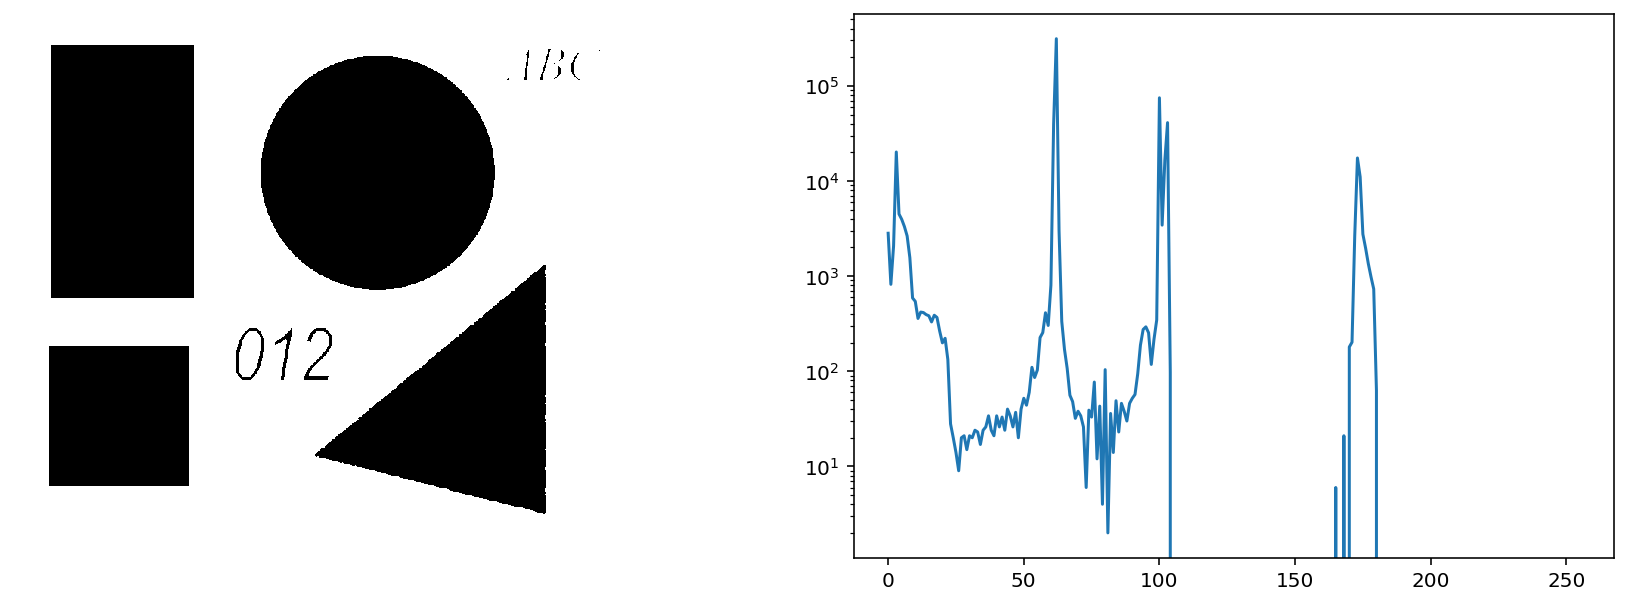

In [5]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
green_mask = cv2.inRange(hls[:, :, 0], 50, 70)

fig = plt.figure(figsize=(15, 5))
fig.add_subplot(121)
plt.axis('off')
plt.imshow(green_mask, cmap='gray')
fig.add_subplot(122)
hist = cv2.calcHist([hls[:, :, 0]], [0], None, [256], [0, 256])
plt.plot(hist)
plt.yscale('log')
plt.show()
del hist, fig

0.9905773576930155 0.20223014176627188


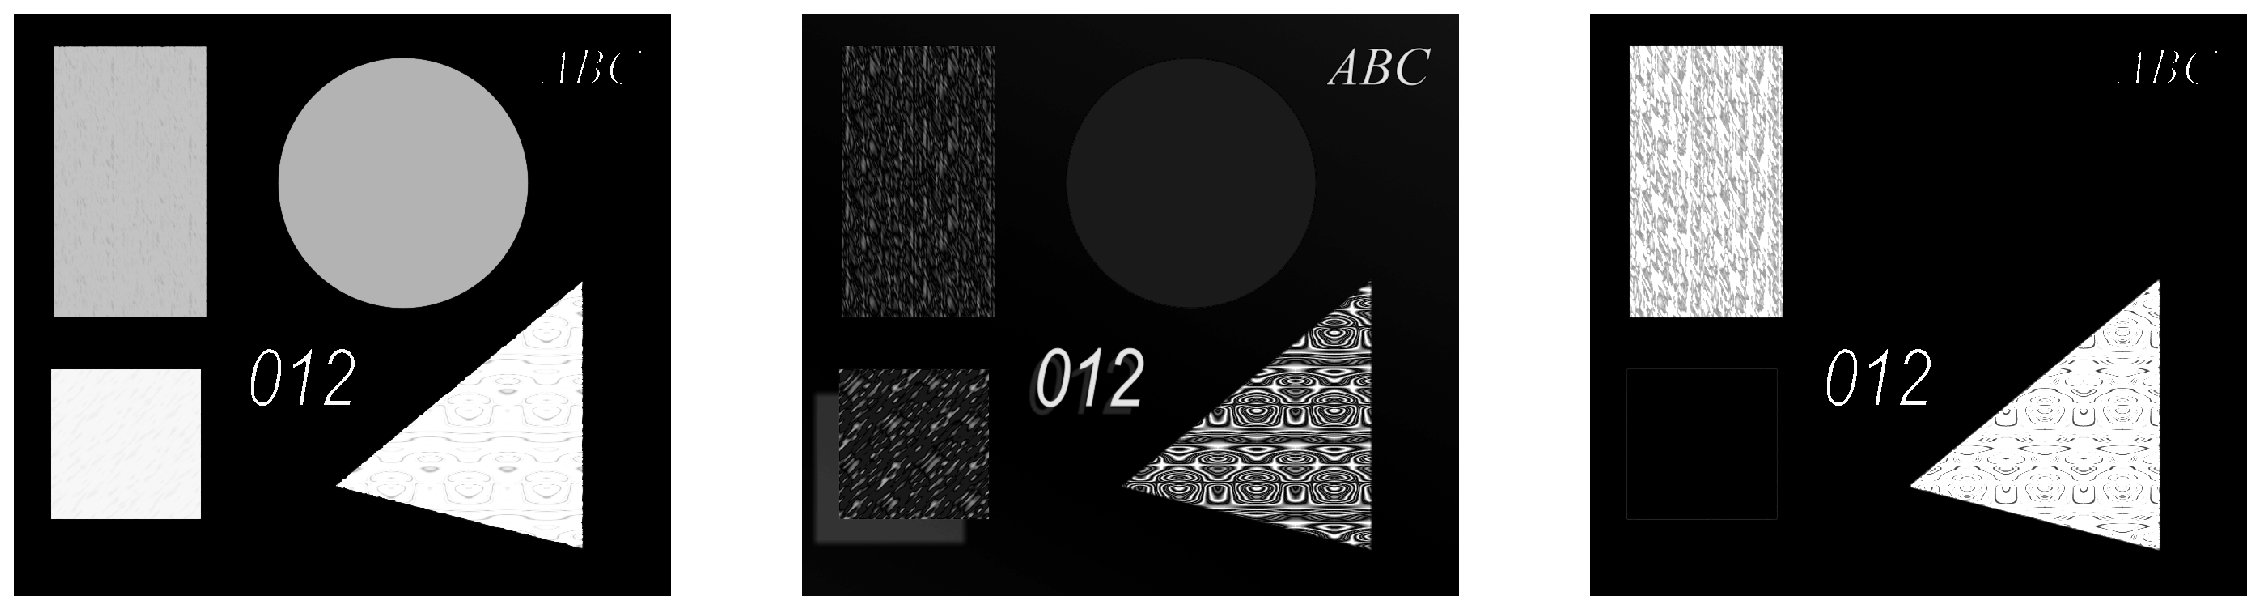

In [6]:
dist_h, max_h = pdi.get_distance_from_mask_max(hls, 0, 180, True, green_mask)
dist_l, max_l = pdi.get_distance_from_mask_max(hls, 1, 255, False, green_mask)
dist_s, max_s = pdi.get_distance_from_mask_max(hls, 2, 255, False, green_mask)

dist_s[dist_s < 0] *= 1.8
dist_s = np.clip(dist_s, -255, 255)

dist_h = np.abs(dist_h)
dist_l = np.abs(dist_l)
dist_s = np.abs(dist_s)

dist_h, _, _ = pdi.remove_outliers(dist_h.astype(np.uint8), .1, 99.9)
dist_l, _, _ = pdi.remove_outliers(dist_l.astype(np.uint8), .1, 99.9)
dist_s, _, _ = pdi.remove_outliers(dist_s.astype(np.uint8), .1, 99.9)

dist_h = dist_h.astype(float) / max(max_h, 180-max_h)
dist_l = dist_l.astype(float) / max(max_l, 255-max_l)
dist_s = dist_s.astype(float) / max(max_s, 255-max_s)

th_dist_h = 0.2
th_dist_l = 0.7
th_dist_s = 0.75
dist_h[dist_h > th_dist_h] += (dist_h[dist_h > th_dist_h] - th_dist_h) * 2
dist_l[dist_l > th_dist_l] += (dist_l[dist_l > th_dist_l] - th_dist_l) * 3
dist_s[dist_s > th_dist_s] += (dist_s[dist_s > th_dist_s] - th_dist_s) * 2

dist_h = 1 / (1 + np.exp(-3*(dist_h-0.5)))
dist_l = 1 / (1 + np.exp(-4*(dist_l-0.35)))
dist_s = 1 / (1 + np.exp(-2*(dist_s-0.6)))

print(np.max(dist_l), np.min(dist_l))

fig = plt.figure(figsize=(20, 15))
fig.add_subplot(131)
plt.axis('off')
plt.imshow(dist_h, cmap='gray')
fig.add_subplot(132)
plt.axis('off')
plt.imshow(dist_l, cmap='gray')
fig.add_subplot(133)
plt.axis('off')
plt.imshow(dist_s, cmap='gray')
del fig

0.3107211382692608 1.0


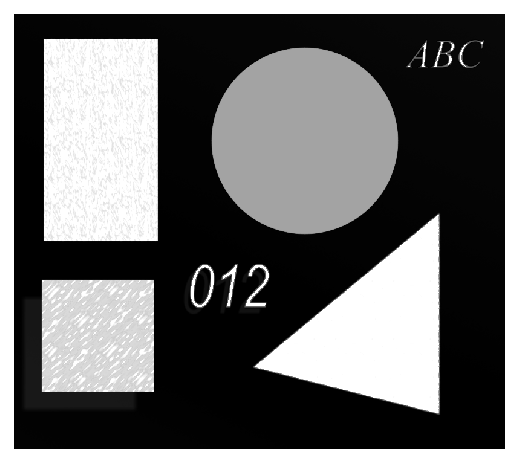

In [7]:
weight_h = 1.2
weight_l = 0.7
weight_s = 0.65
dists = pdi.ln_norm((weight_h*dist_h, weight_l*dist_l, weight_s*dist_s), 1)
dists *= 0.6
dists = np.clip(dists, 0, 1)
print(np.min(dists), np.max(dists))

plt.axis('off')
plt.imshow(dists, cmap='gray')

In [8]:
def merge_with_thresholds(fg, bg, alpha, low_th, high_th):
    alpha = pdi.stretch_normalize(alpha, low_th, high_th, 0, 1)
    alpha_rgb = np.empty(fg.shape)
    alpha_rgb[:, :, 0] = alpha
    alpha_rgb[:, :, 1] = alpha
    alpha_rgb[:, :, 2] = alpha

    fg = cv2.multiply(alpha_rgb, fg.astype(float))
    bg = cv2.multiply(1.0 - alpha_rgb, bg.astype(float))
    result = cv2.add(fg, bg).astype(np.uint8)
    return result

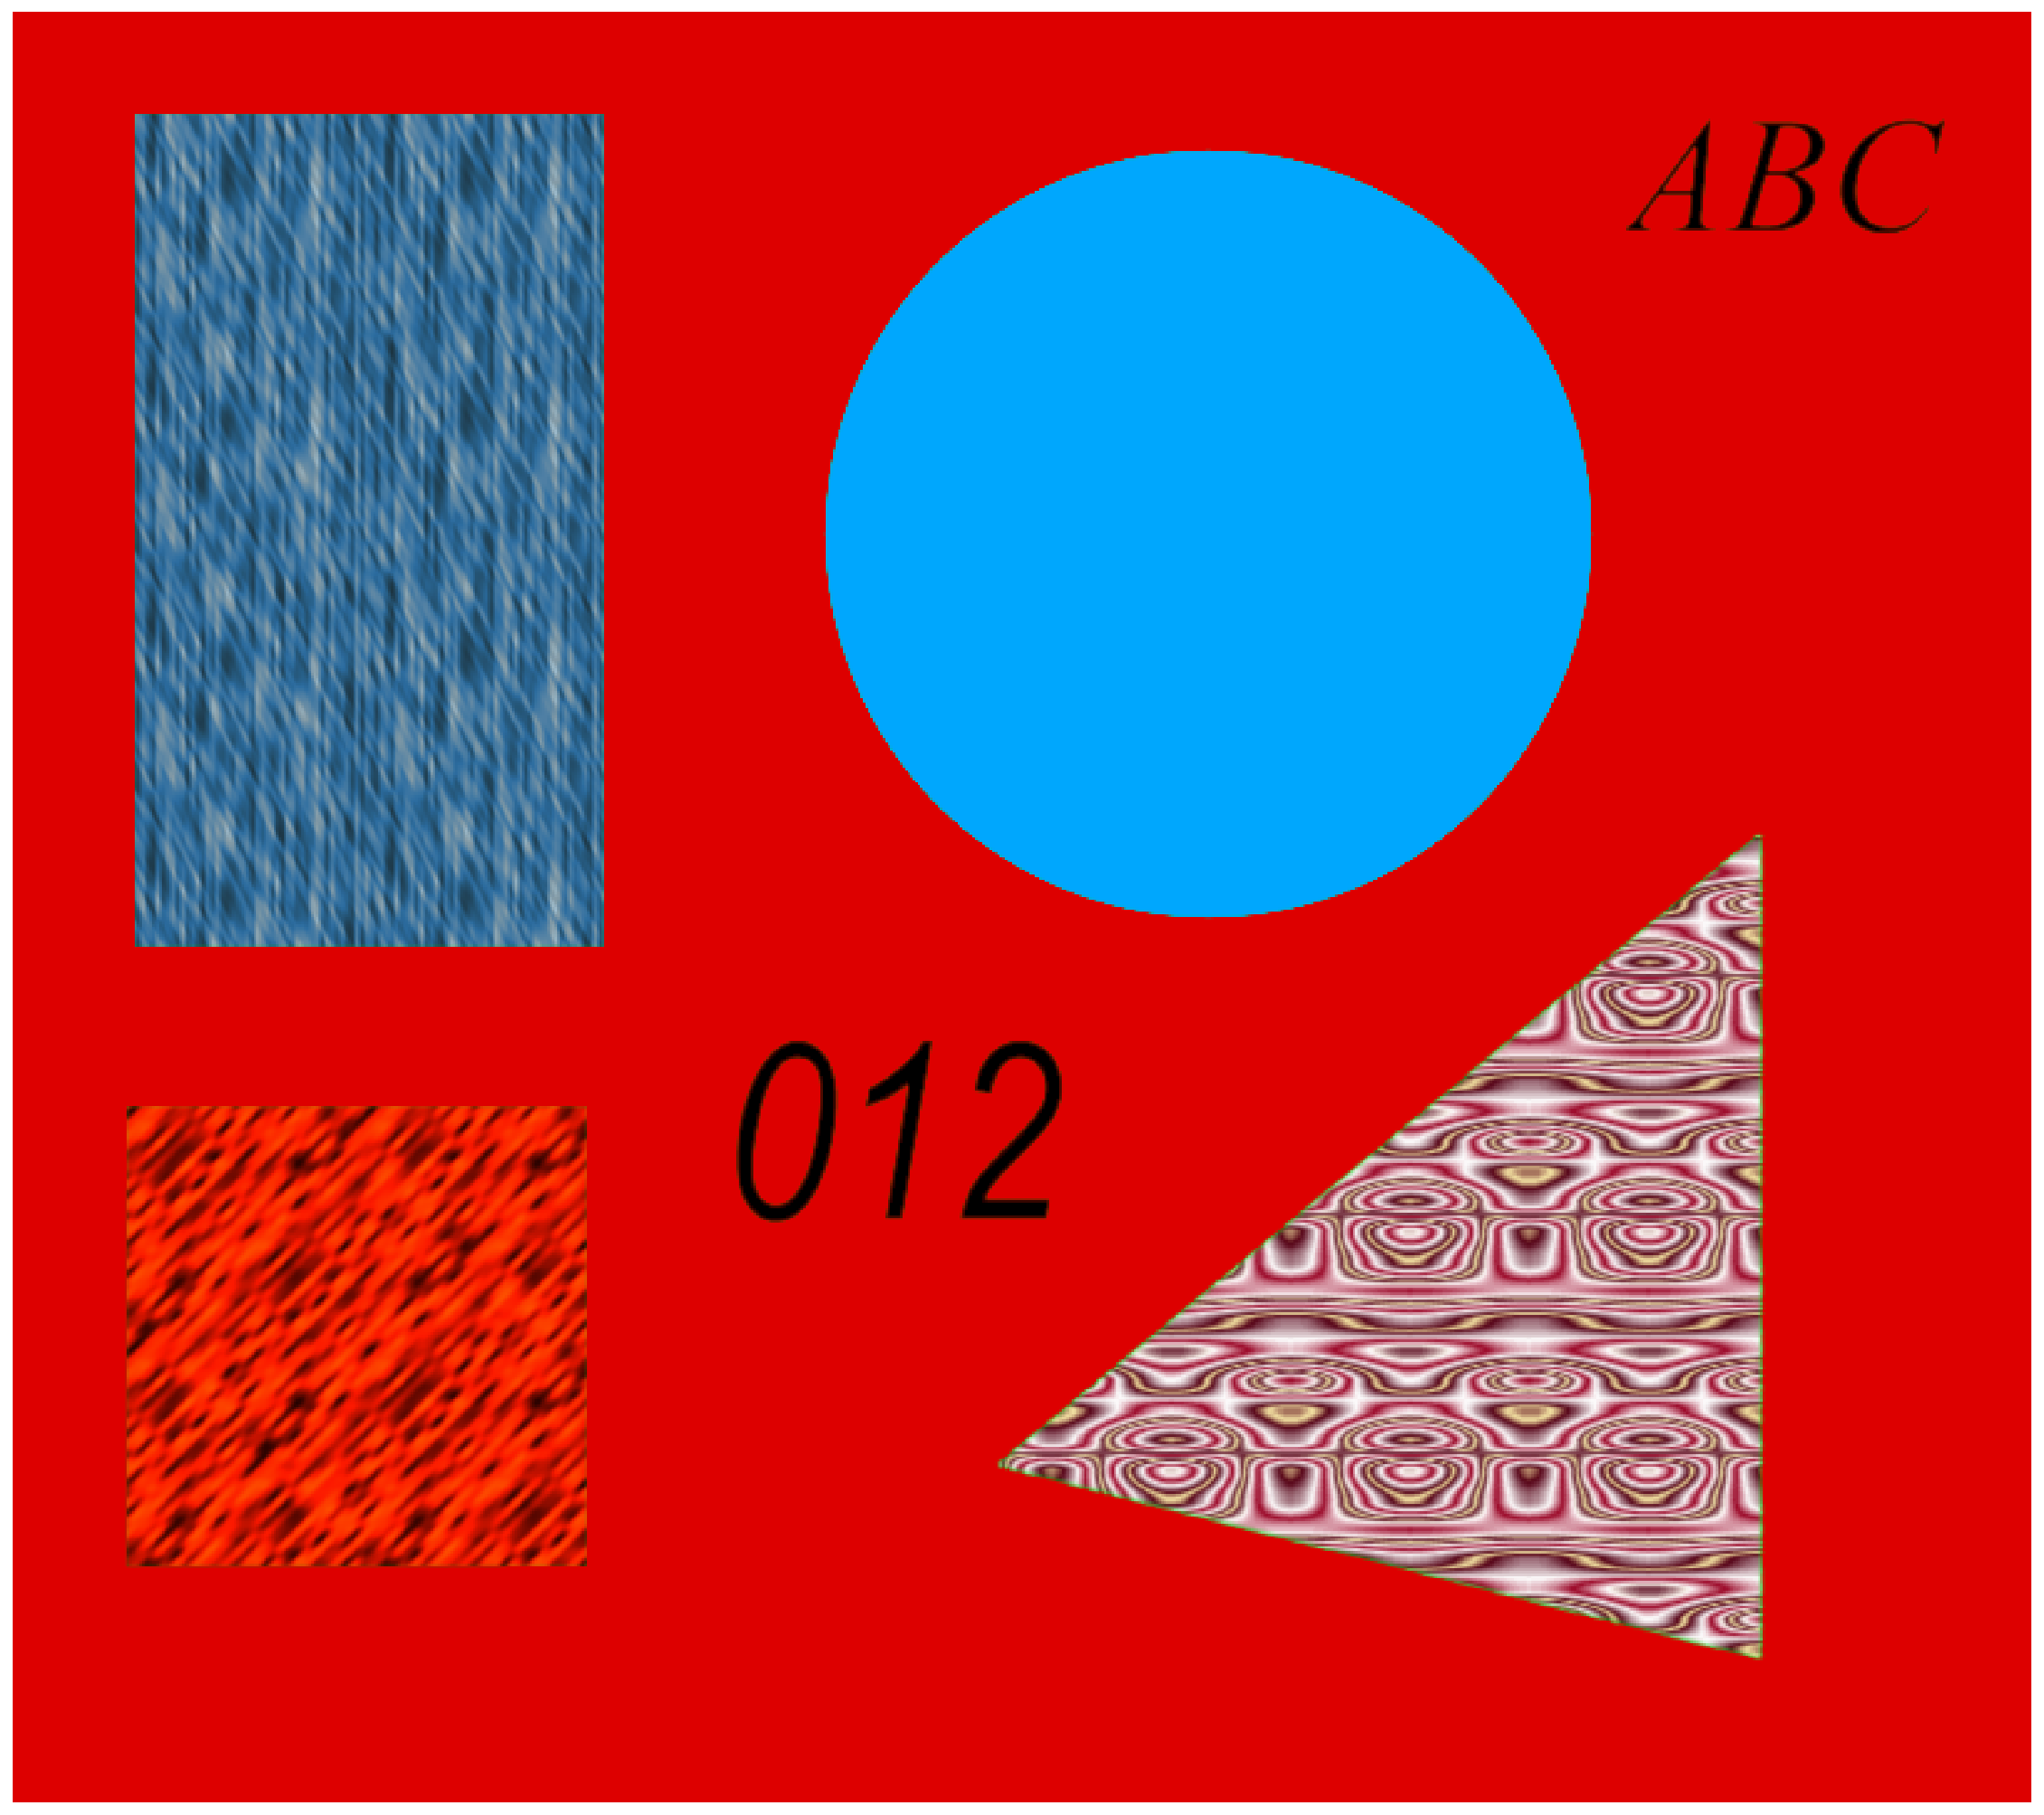

In [9]:
merge = apply_green_screen(img, bg_img, dists, 0.4, 0.65)

fig = plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(merge)
del fig, merge

In [10]:
plt.close('all')